In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["KERAS_BACKEND"]="tensorflow"


In [2]:
import sys
sys.path.append('..')



In [3]:
import warnings
warnings.simplefilter("ignore")



In [4]:
import numpy as np

import keras
import keras.backend as K



Using TensorFlow backend.


In [5]:
K.set_image_data_format('channels_last')



In [6]:
from matplotlib import pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')

# helper to simplify displaying multiple images
def imshow(image, width=64, height=64, size=None):
    
    im = np.array(image, copy=True)
    if image.min() < 0:
        im -= im.min()
    im /= im.max()
    im = (im*255.).astype(np.uint8)
    if np.ndim(im) == 3:
        im = np.expand_dims(im, 0)
 
    n = len(im)
    s = int(np.ceil(np.sqrt(n)))
    
    if size is None:
        size = 2*s
    
    fig, axs = plt.subplots(s, s)
    fig.set_size_inches(size,size)
    if s == 1:
        axs.imshow(im[0])
    else:
        cnt = 0
        for i in range(s):
            for j in range(s):
                if cnt < n:
                    axs[i,j].imshow(im[cnt, :,:,:])
                axs[i,j].axis('off')
                axs[i,j].set_aspect('equal')
                cnt += 1
        fig.subplots_adjust(wspace=0, hspace=0.)

    plt.show()


In [7]:
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people

# Use only classes that have at least 100 images
# There are five such classes in LFW
lfw_slice = (slice(68, 196, None), slice(61, 190, None))
faces_data = fetch_lfw_people(min_faces_per_person=100, color=True, slice_=lfw_slice)
images = faces_data.images
n_classes = faces_data.target.max()+1
x, y = faces_data.data, keras.utils.to_categorical(faces_data.target, n_classes)
images /= 255.0

# Use 3/4 for training, the rest for testing
N_tr = int(len(x)*0.75)
N_te = len(x) - N_tr
x_tr, y_tr = x[:N_tr], y[:N_tr]
x_te, y_te = x[N_tr:], y[N_tr:]
im_tr, im_te = images[:N_tr], images[N_tr:]



C:\Users\mattf\Miniconda3\envs\dl-tf\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


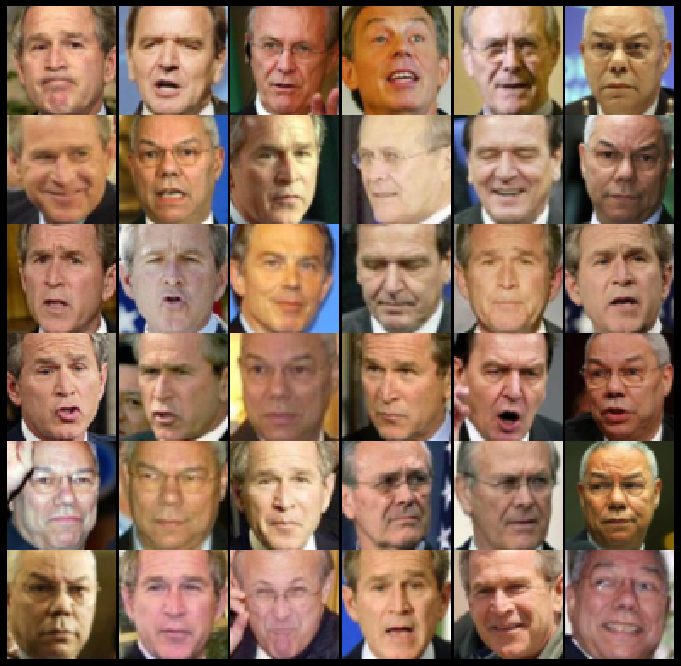

In [8]:
imshow(images[:36])


 We'll use a small convnet to demonstrate, but with enough depth for interesting results

In [9]:
inp = keras.layers.Input(shape=im_tr[0].shape)
out = keras.layers.Conv2D(128, (3,3), activation='relu')(inp)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(64, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(32, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(16, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Flatten()(out)
out = keras.layers.Dense(16, activation='relu')(out)
out = keras.layers.Dense(y[0].shape[0], activation='softmax')(out)
model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_

 The model was originally trained with:

 `model.fit(im_tr, y_tr, batch_size=32, epochs=40, validation_data=(im_te, y_te))`

In [10]:
model.load_weights('examples/weights/lfw-small-tf.h5')


In [11]:
print('accuracy:')
print('train={:.2}'.format(model.evaluate(im_tr, y_tr, verbose=False)[1]))
print('test={:.2}'.format(model.evaluate(im_te, y_te, verbose=False)[1]))


accuracy:
train=1.0
test=0.81


In [12]:
from attribution.model_utils import replace_softmax_with_logits
model = replace_softmax_with_logits(model)


 # Finding invariants

 Now let's find some invariants of the model. The main class for doing so is ``ActivationInvariants``.

In [13]:
from attribution.ActivationInvariants import ActivationInvariants
from attribution.InfluenceInvariants import InfluenceInvariants


In [14]:
for layer in range(1,len(model.layers)-1):
    actinv = ActivationInvariants(model, layers=[layer], agg_fn=None).compile()
    infinv = InfluenceInvariants(model, layer=layer, agg_fn=None).compile()

    invs_act = actinv.get_invariants(im_tr)
    invs_inf = infinv.get_invariants(im_tr)

    supports_act = [inv.support for inv in invs_act]
    supports_inf = [inv.support for inv in invs_inf]
    print('layer {}, act: #={}, avg supp.: {:.2}'.format(layer, len(invs_act), np.array(supports_act).mean()))
    print('layer {}, inf: #={}, avg supp.: {:.2}'.format(layer, len(invs_inf), np.array(supports_inf).mean()))
    print('-'*20)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
layer 1, act: #=128, avg supp.: 0.039
layer 1, inf: #=74, avg supp.: 0.068
--------------------
layer 2, act: #=138, avg supp.: 0.036
layer 2, inf: #=56, avg supp.: 0.089
--------------------
layer 3, act: #=156, avg supp.: 0.032
layer 3, inf: #=79, avg supp.: 0.063
--------------------
layer 4, act: #=171, avg supp.: 0.029
layer 4, inf: #=59, avg supp.: 0.085
--------------------
layer 5, act: #=158, avg supp.: 0.032
layer 5, inf: #=84, avg supp.: 0.06
--------------------
layer 6, act: #=222, avg supp.: 0.023
layer 6, inf: #=40, avg supp.: 0.12
--------------------
layer 7, act: #=251, avg supp.: 0.02
layer 7, inf: #=34, avg supp.: 0.15
--------------------
layer 8, act: #=131, avg supp.: 0.0096
layer 8, inf: #=7, avg supp.: 0.71
--------------------
layer 9, act: #=132, avg supp.: 0.0095
layer 9, inf: #=7, avg supp.: 0.71
--------------------
layer 10, act: #